This notebook evaluates and plots training time in the IVF and HNSW indexes

In [1]:
import pickle
import collections
import matplotlib.pyplot as plt
import faiss
import numpy as np
import itertools
import statistics
import matplotlib.cm as cm
import time
import os
from time import perf_counter_ns

In [2]:
# read in embeddings and cluster label info
with open('embedding64.pickle', 'rb') as fp:
    embedding64 = pickle.load(fp)
with open('label_info.pickle', 'rb') as fp:
    label_info = pickle.load(fp)

print(embedding64.keys())
print(label_info.keys())

dict_keys(['embed_all', 'embed_raw', 'embed_l2_norm', 'restore_order', 'embed_correct_coverage_fh', 'embed_l2_norm_correct_coverage_fh'])
dict_keys(['batch id', 'age', 'total_cg', 'average_cg_rate', 'total_ch', 'average_ch_rate', 'hic_counts', 'cell_name_higashi', 'major', 'minor', 'cluster label', 'cluster label minor'])


In [3]:
# create helpful dicts for the cluster labels
# also look at n counts for the clusters
major_labels = list(set(label_info['cluster label']))
minor_labels = list(set(label_info['cluster label minor']))

major = dict(zip(major_labels,[[] for item in major_labels]))
minor = dict(zip(minor_labels,[[] for item in minor_labels]))

true_major = label_info['cluster label']
true_minor = label_info['cluster label minor']

for j in range(len(label_info['cluster label'])):
    maj = label_info['cluster label'][j]
    min = label_info['cluster label minor'][j]

    if maj in major.keys():
        major[maj].append(j)
    if min in minor.keys():
        minor[min].append(j)

print("MAJOR CLUSTERS")
for key in major.keys():
    s = "    " + key + ": " + str(len(major[key]))
    print(s)
    
print("MINOR CLUSTERS")
for key in minor.keys():
    s = "    " + key + ": " + str(len(minor[key]))
    print(s)

MAJOR CLUSTERS
    Pvalb: 134
    OPC: 203
    MP: 100
    ODC: 1245
    L5: 180
    L4: 131
    Ndnf: 144
    Sst: 217
    Astro: 449
    MG: 422
    L2/3: 551
    Vip: 171
    L6: 86
    Endo: 205
MINOR CLUSTERS
    Pvalb-2: 21
    Vip-1: 45
    Endo-2: 69
    OPC-1: 203
    MG-1: 422
    Vip-2: 126
    Ndnf-3: 22
    Sst-1: 50
    Sst-2: 107
    MP-1: 100
    L5-3: 58
    L5-2: 74
    Pvalb-1: 113
    L2/3-4: 150
    L2/3-3: 127
    L5-1: 48
    ODC-1: 810
    Astro-1: 449
    Sst-3: 60
    Endo-3: 85
    L2/3-1: 137
    ODC-2: 435
    Ndnf-1: 59
    L6-2: 19
    L2/3-2: 137
    Ndnf-2: 63
    Endo-1: 51
    L4-1: 131
    L6-1: 67


In [4]:
# create input database
database = np.array(embedding64["embed_l2_norm"]) 

IVF experiment

In [5]:
# define experiment function
def IVF_flat_experiment(nlist):
    # initialize empty arrays for results
    train_time = np.zeros([4238])
    
    for i in range(4238):
        # subset dataset
        db_subset = np.delete(database, i, 0)
        
        # create and train index
        quantizer = faiss.IndexFlatL2(64)
        index = faiss.IndexIVFFlat(quantizer, 64, nlist)
        
        start1 = perf_counter_ns()
        index.train(db_subset)
        end1 = perf_counter_ns()

        train_time[i] = (end1-start1)

    return train_time    

In [6]:
TrainTime_A = IVF_flat_experiment(17)
TrainTime_B = IVF_flat_experiment(47)
TrainTime_C = IVF_flat_experiment(77)
TrainTime_D = IVF_flat_experiment(107)
TrainTime_E = IVF_flat_experiment(137)

In [7]:
with open('IVFFLAT/TrainTime.npy', 'wb') as f:
    np.save(f, TrainTime_A)
    np.save(f, TrainTime_B)
    np.save(f, TrainTime_C)
    np.save(f, TrainTime_D)
    np.save(f, TrainTime_E)

HNSW experiment

In [8]:
# define experiment function
def HNSW_experiment(index_str):
    # initialize empty arrays for results
    train_time = np.zeros([4238])
    
    for i in range(4238):
        # subset dataset
        db_subset = np.delete(database, i, 0)
        
        # create and train index
        index = faiss.index_factory(64, index_str)
        
        start1 = perf_counter_ns()
        index.train(db_subset)
        end1 = perf_counter_ns()
        
        train_time[i] = (end1-start1)        

    return train_time    

In [9]:
TrainTimeH_A = HNSW_experiment("HNSW16,Flat")
TrainTimeH_B = HNSW_experiment("HNSW32,Flat")
TrainTimeH_C = HNSW_experiment("HNSW64,Flat")
TrainTimeH_D = HNSW_experiment("HNSW128,Flat")

In [10]:
with open('HNSW/TrainTime.npy', 'wb') as f:
    np.save(f, TrainTimeH_A)
    np.save(f, TrainTimeH_B)
    np.save(f, TrainTimeH_C)
    np.save(f, TrainTimeH_D)

Create figures with training time

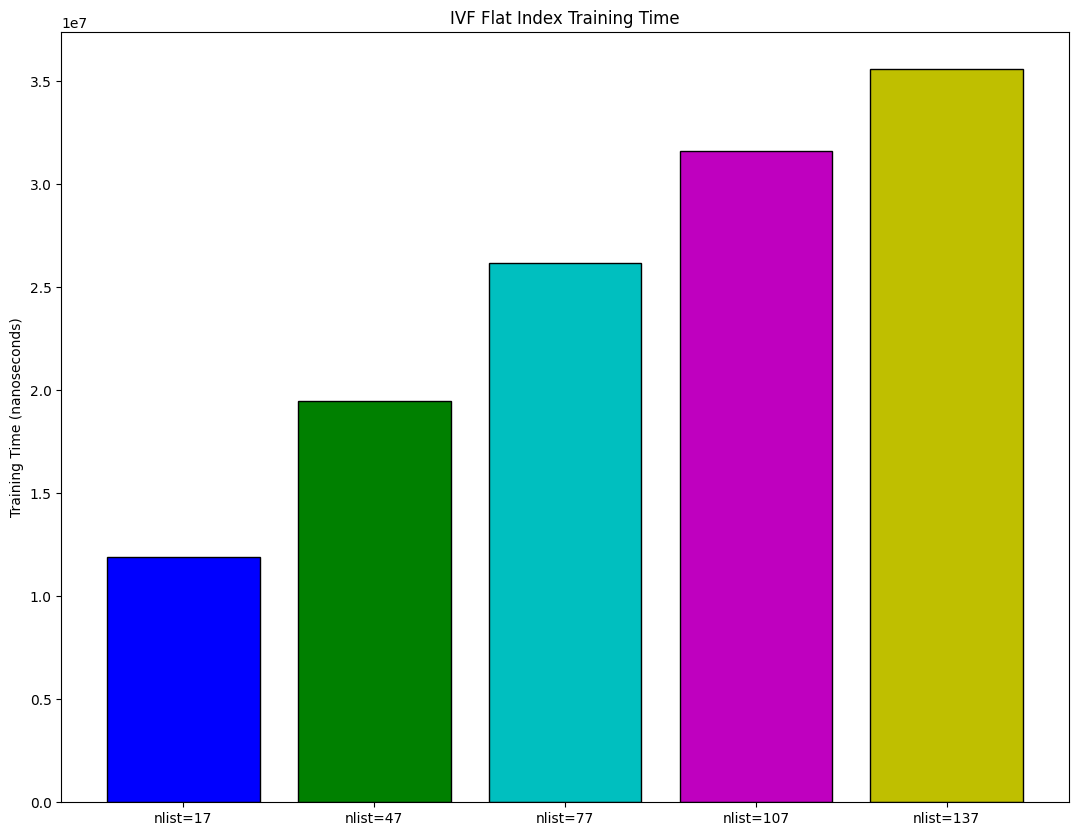

In [28]:
fig, (ax1) = plt.subplots(1)
fig.set_size_inches(13, 10)
colors=["b", "g", "c", "m", "y"]

ax1.bar(['17', '47', '77', '107', '137'], tti, color=colors, edgecolor="black")
# ax1.set_yticks([500,1000,1500,2000,2500,3000,3500,4000])
ax1.set_xticks([r for r in range(len(tti))],['nlist=17', 'nlist=47', 'nlist=77', 'nlist=107', 'nlist=137'])
ax1.set_ylabel('Training Time (nanoseconds)')
ax1.set_title('IVF Flat Index Training Time')
plt.show()
fig.savefig("TrainingTimeIVFFLAT.png")

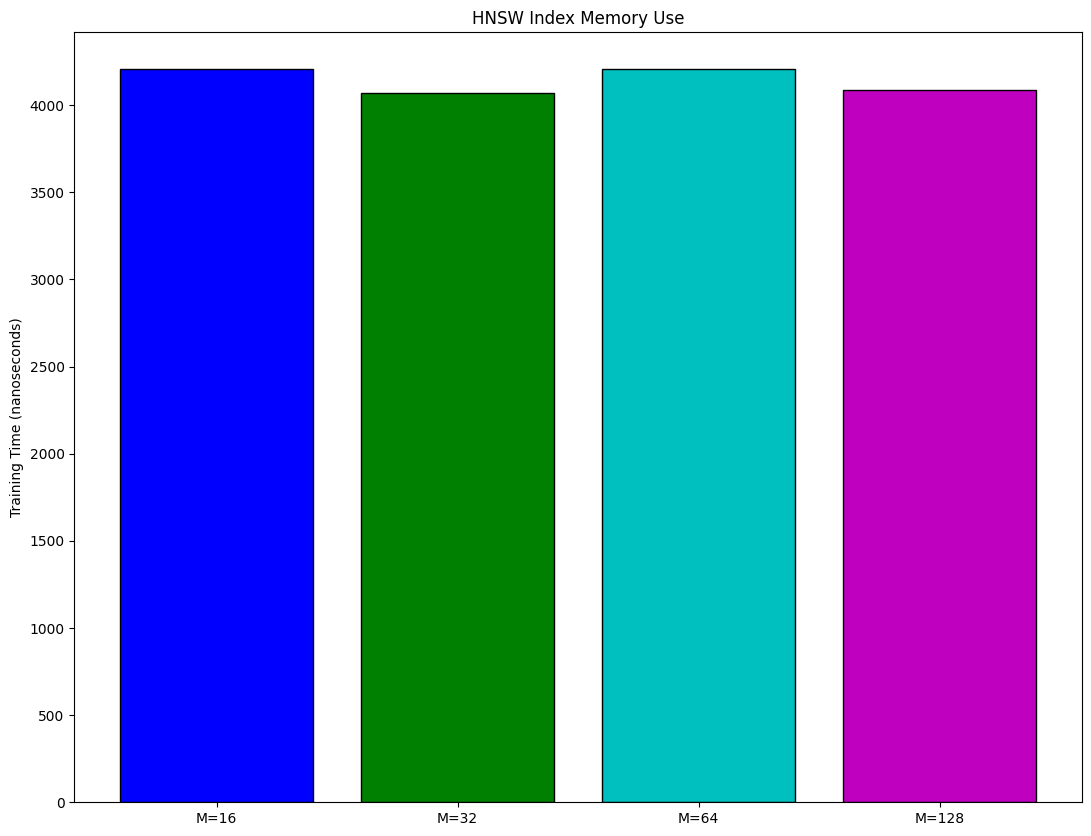

In [29]:
fig, (ax1) = plt.subplots(1)
fig.set_size_inches(13, 10)

colors=["b", "g", "c", "m"]

ax1.bar(['M=16', 'M=32', 'M=64', 'M=128'], tth, color=colors, edgecolor="black")
ax1.set_xticks([r for r in range(len(tth))],['M=16', 'M=32', 'M=64', 'M=128'])
ax1.set_ylabel('Training Time (nanoseconds)')
ax1.set_title('HNSW Index Memory Use')
plt.show()
fig.savefig("TrainingTimeHNSW.png")